<a href="https://colab.research.google.com/github/physicaone/loss_IG/blob/master/%5B210902%5Dvisual_result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np
import torch
import torchvision.datasets
import torchvision.models
import torchvision.transforms
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.utils.data
import torch.nn as nn
from tqdm import tqdm, tnrange
import warnings
warnings.filterwarnings("ignore")
import random
import pickle as pkl
import pandas as pd
from scipy.stats import entropy
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
CUDA = torch.cuda.is_available()
CUDA_DEVICE = 0

try:
    from google.colab import drive
    drive.mount('/content/drive')
    base='drive/MyDrive'
except:
    if torch.cuda.device_count()>1:
        base='.'
    else:
        base='Google Drive'

if CUDA:
    device='cuda'
else:
    device='cpu'
torch.cuda.is_available()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


False

In [2]:
def decimal_to_binary(integer, n_hid):
    string=bin(int(integer))[2:]
    list0=[float(d) for d in string]
    while len(list0)<n_hid:
        list0=[0.]+list0
    return torch.tensor([list0])

def Ising_energy(v_list):
    L = 3
    E_list=[]
    for n in range(len(v_list)):
        v=v_list[n]
        E = 0
        for i in range(L):
            for j in range(L):
                s = v[i,j]
                neigh = v[(i+1)%L, j] + v[i,(j+1)%L] + v[(i-1)%L,j] + v[i,(j-1)%L] 
                E += -neigh * s
        E_list.append(E/2)
    return np.array(E_list)
    
class RBM(nn.Module):

    def __init__(self, n_vis, n_hid, k):
        """Create a RBM."""
        super(RBM, self).__init__()
        
        self.v_bias = nn.Parameter(torch.zeros(1, n_vis).to(device))
        self.h_bias = nn.Parameter(torch.zeros(1, n_hid).to(device))
        self.Weight = nn.Parameter(torch.randn(n_hid, n_vis).to(device)*0.5)
        self.k = k


    def v2h(self, v):
        return torch.sigmoid(F.linear(v, self.Weight, self.h_bias))

    def h2v(self, h):
        return torch.sigmoid(F.linear(h, self.Weight.t(), self.v_bias))
    
    def Fv(self, v):
        v_term = torch.matmul(v, self.v_bias.t()).view(len(v))
        h_term = torch.sum(F.softplus(F.linear(v, self.Weight, self.h_bias)), dim=1)
        return -h_term -v_term

    def energy(self, v, h):
        v=v.bernoulli()
        h=h.bernoulli()
        return -torch.matmul(v, self.v_bias.t())-torch.matmul(torch.matmul(v, self.Weight.t()),h.t())-torch.matmul(h, self.h_bias.t())
    
    def Energy_GPU2(self, v_list0, h_list0):
        if CUDA:
            n_split=torch.cuda.device_count()
        else:
            n_split=1
        e_list=[]
        m_split=2**6
        for j in range(m_split):
            v_list1=torch.stack(list(v_list0[j*int(len(v_list0)/m_split):(j+1)*int(len(v_list0)/m_split)]))
            h_list1=torch.stack(list(h_list0[j*int(len(h_list0)/m_split):(j+1)*int(len(h_list0)/m_split)]))
            vs=[]
            hs=[]
            for i in range(n_split):
                v_list2=torch.stack(list(v_list1[i*int(len(v_list1)/n_split):(i+1)*int(len(v_list1)/n_split)]))
                h_list2=torch.stack(list(h_list1[i*int(len(h_list1)/n_split):(i+1)*int(len(h_list1)/n_split)]))
                if CUDA:
                    v_list2=v_list2.to(device='cuda:' + str(i)).view(len(v_list2), n_vis)
                    h_list2=h_list2.to(device='cuda:' + str(i)).view(len(h_list2), n_hid)
                else:
                    None
                vs.append(v_list2)
                hs.append(h_list2)
            for i in range(n_split): 
                if CUDA:
                    a=self.v_bias.to(device='cuda:' + str(i)).view(n_vis)
                    b=self.h_bias.to(device='cuda:' + str(i)).view(n_hid)
                    W=self.Weight.to(device='cuda:' + str(i)).view(n_hid, n_vis)
                    e=(-torch.matmul(vs[i].float(), a)-torch.diagonal(torch.matmul(torch.matmul(vs[i].float(), W.t()), hs[i].float().t()))-torch.matmul(hs[i].float(), b)).to('cuda:0')
                    e_list.append(e)
                else:
                    a=self.v_bias.view(n_vis)
                    b=self.h_bias.view(n_hid)
                    W=self.Weight.view(n_hid, n_vis)
                    e=(-torch.matmul(vs[i].float(), a)-torch.diagonal(torch.matmul(torch.matmul(vs[i].float(), W.t()), hs[i].float().t()))-torch.matmul(hs[i].float(), b))
                    e_list.append(e)
        return torch.stack(e_list).view(len(v_list0))
    
    def forward(self, v):
        h = self.v2h(v)
        h = h.bernoulli()
        for _ in range(self.k):
            v_gibbs = self.h2v(h).to(device)
            v_gibbs = v_gibbs.bernoulli()
            h = self.v2h(v_gibbs).to(device)
            h = h.bernoulli()
        return v, v_gibbs
        

In [3]:
# Hyper parameter들을 설정
n_vis=9
k=5
lr=0.1
vol=512
batch_size=int(vol/2)
epoch_to_save=[2**i for i in range(21)]
n_epochs=epoch_to_save[-1]+1

In [48]:
n_hid_list=[1,2,4,8]
T_list=[1.47, 1.78, 2.3, 5.2, 16]
epoch_to_save=[2**i for i in range(20)]
T_color=['red', 'orange', 'green', 'blue', 'purple']
n_hid_color=['red', 'orange', 'green', 'blue', 'purple']
lr=0.1
vol=512
std=''

In [49]:
Train_loss={}
IG_loss={}
for T in T_list:
    Train_loss[str(T)]={}
    IG_loss[str(T)]={}
    for n_hid in n_hid_list:
        Train_loss[str(T)][str(n_hid)]=pd.read_pickle('{base}/loss_IG/3*3/loss/train_loss_n_hid={n_hid}_T={T}_lr={lr}_vol={vol}.pkl'.format(base=base, n_hid=n_hid, T=T, lr=lr, vol=vol, std=std))
        IG_loss[str(T)][str(n_hid)]=pd.read_pickle('{base}/loss_IG/3*3/loss/IG_loss_n_hid={n_hid}_T={T}_lr={lr}_vol={vol}.pkl'.format(base=base, n_hid=n_hid, T=T, lr=lr, vol=vol, std=std))


IndexError: ignored

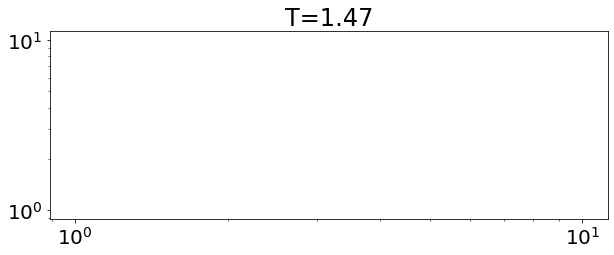

In [57]:
x_mark=[1,10,100,1000,10000,100000,1000000]
# y_mark=[0.001, 0.01, 0.1, 0.4]

plt.figure(figsize=(10,20))

# plt.ylim(y_mark[0],y_mark[-1])
for j in range(len(T_list)):
    plt.subplot(len(T_list), 1, j+1)
    plt.title('T={T}'.format(T=T_list[j]))
    plt.rcParams["font.size"] = "20"
    plt.xscale('log')
    plt.yscale('log')
    for i in range(len(n_hid_list)):
#         plt.plot(epoch_to_save, Train_loss[str(T_list[j])][str(n_hid_list[i])], '-.', c=n_hid_color[i], label='_nolegend_')
        plt.plot(epoch_to_save, IG_loss[str(T_list[j])][str(n_hid_list[i])], '-o', c=n_hid_color[i], label = n_hid_list[i])

        plt.xticks([])
plt.xticks(x_mark)
# plt.yticks(y_mark, y_mark)
plt.xlabel('epoch')

plt.legend(n_hid_list, bbox_to_anchor=(1, 1), 
        ncol=1, fancybox=True, shadow=True)


In [53]:
n_hid_list=[1,2,4,8]
T_list=[1.47, 1.78, 2.3, 5.2, 16]
epoch_to_save=[2**i for i in range(21)]
T_color=['red', 'orange', 'green', 'blue', 'purple']
n_hid_color=['red', 'orange', 'green', 'blue', 'purple']
lr=0.1
vol=512
std='half'

In [54]:
Fv={}
FE={}
for T in T_list:
    Fv[str(T)]={}
    FE[str(T)]={}
    for n_hid in n_hid_list:
        v_list_ising=[]
        v_list_ising2=[]
        for s in range(2**n_vis):
            v=decimal_to_binary(s, n_vis)[0]
            v_list_ising.append(np.reshape(v,(3,3))*2-1)
            v_list_ising2.append(v)
        v_list_ising2=torch.stack(v_list_ising2).to(device)
        bf_list=np.exp(-Ising_energy(v_list_ising)/T)
        S=entropy(bf_list)
        IG_loss=pd.read_pickle('{base}/loss_IG/3*3/loss/IG_loss_n_hid={n_hid}_T={T}_lr={lr}_vol={vol}_std_{std}.pkl'.format(base=base, n_hid=n_hid, T=T, lr=lr, vol=vol, std=std))
        models=pd.read_pickle('{base}/loss_IG/3*3/state_dict/model_n_hid={n_hid}_T={T}_lr={lr}_vol={vol}_std_{std}.pkl'.format(base=base, n_hid=n_hid, T=T, lr=lr, vol=vol, std=std))
        
        Fv[str(T)][str(n_hid)]=[]
        FE[str(T)][str(n_hid)]=[]
        for i in range(len(models)):
            rbm=RBM(n_vis, n_hid, k)
            rbm.load_state_dict(models[i])
            Fv_tmp=torch.mean(rbm.Fv(v_list_ising2)).detach().numpy()
            Fv[str(T)][str(n_hid)].append(Fv_tmp)
            FE[str(T)][str(n_hid)].append(-IG_loss[i]+Fv_tmp-S)


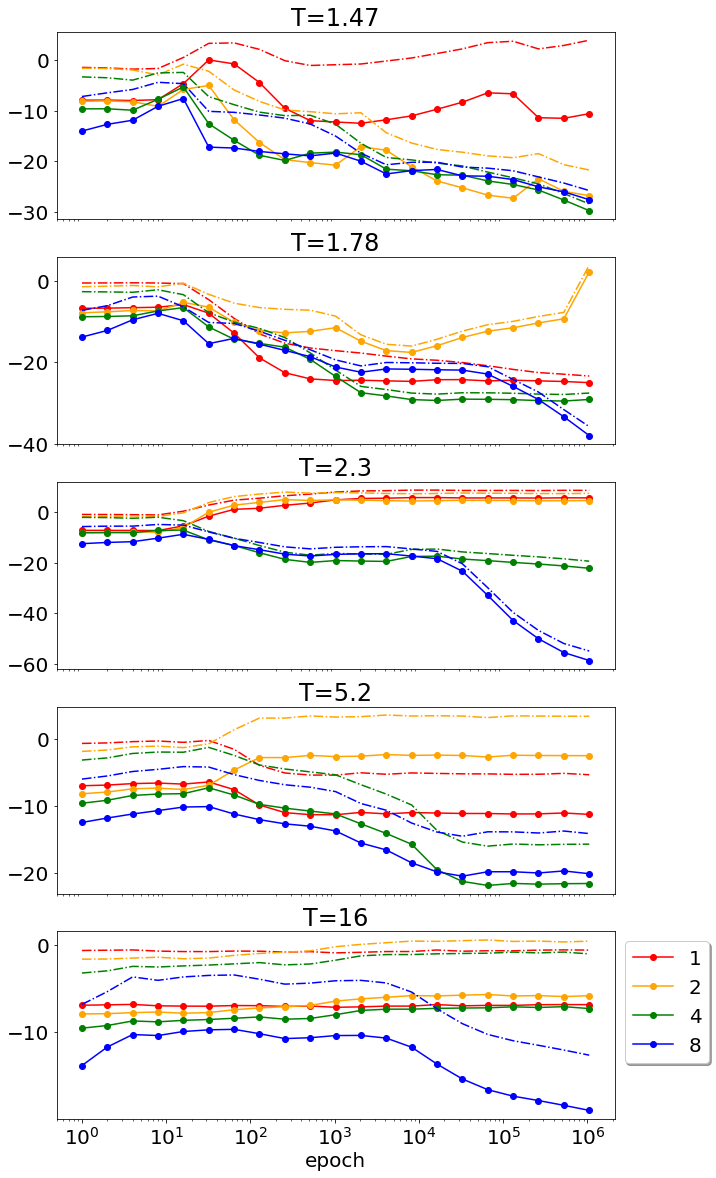

In [56]:
x_mark=[1,10,100,1000,10000,100000,1000000]
# y_mark=[0.001, 0.01, 0.1, 0.4]

plt.figure(figsize=(10,20))

# plt.ylim(y_mark[0],y_mark[-1])
for j in range(len(T_list)):
    plt.subplot(len(T_list), 1, j+1)
    plt.title('T={T}'.format(T=T_list[j]))
    plt.rcParams["font.size"] = "20"
    plt.xscale('log')
#     plt.yscale('log')
    for i in range(len(n_hid_list)):
        plt.plot(epoch_to_save, FE[str(T_list[j])][str(n_hid_list[i])], '-o', c=n_hid_color[i], label = n_hid_list[i])
        plt.plot(epoch_to_save, Fv[str(T_list[j])][str(n_hid_list[i])], '-.', c=n_hid_color[i], label = None)

        plt.xticks([])
plt.xticks(x_mark)
# plt.yticks(y_mark, y_mark)
plt.xlabel('epoch')

plt.legend(bbox_to_anchor=(1, 1), 
        ncol=1, fancybox=True, shadow=True)


In [78]:
n_hid_list=[1,2,4,8]
T_list=[1.47, 1.78, 2.3, 5.2, 16]
T_color=['red', 'orange', 'green', 'blue', 'purple']
n_hid_color=['red', 'orange', 'green', 'blue', 'purple']
lr=0.1
std='half'

In [79]:
Fv={}
nFE={}
for T in T_list:
    Fv[str(T)]=[]
    nFE[str(T)]=[]
    for n_hid in n_hid_list:
        v_list_ising=[]
        v_list_ising2=[]
        for s in range(2**n_vis):
            v=decimal_to_binary(s, n_vis)[0]
            v_list_ising.append(np.reshape(v,(3,3))*2-1)
            v_list_ising2.append(v)
        v_list_ising2=torch.stack(v_list_ising2).to(device)
        bf_list=np.exp(-Ising_energy(v_list_ising)/T)
        S=entropy(bf_list)
        models=pd.read_pickle('{base}/loss_IG/3*3/state_dict/model_n_hid={n_hid}_T={T}_lr={lr}_vol={vol}_std_{std}.pkl'.format(base=base, n_hid=n_hid, T=T, lr=lr, vol=vol, std=std))
        IG_loss=pd.read_pickle('{base}/loss_IG/3*3/loss/IG_loss_n_hid={n_hid}_T={T}_lr={lr}_vol={vol}_std_{std}.pkl'.format(base=base, n_hid=n_hid, T=T, lr=lr, vol=vol, std=std))
        rbm=RBM(n_vis, n_hid, k)
        rbm.load_state_dict(models[-2])
        
        Fv[str(T)].append(torch.mean(rbm.Fv(v_list_ising2)).detach().numpy())
        nFE[str(T)].append(IG_loss[-2])
        

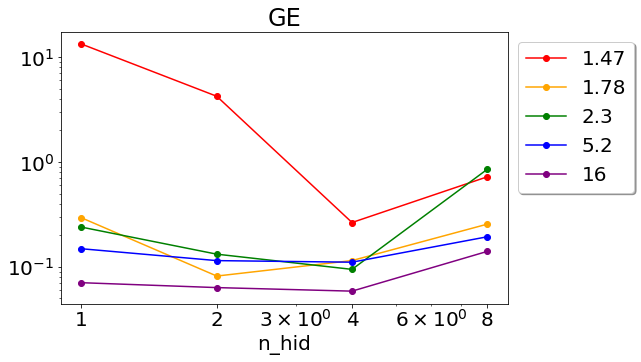

In [82]:

x_mark=[1,2,4,8]
# y_mark=[0.001, 0.01, 0.1, 0.4]

plt.figure(figsize=(8,5))

# plt.ylim(y_mark[0],y_mark[-1])
plt.title('GE')
plt.rcParams["font.size"] = "20"
plt.xscale('log')
plt.yscale('log')
for j in range(len(T_list)):

    plt.plot(n_hid_list, nFE[str(T_list[j])], '-o', color=T_color[j], label = T_list[j])
    # plt.plot(n_hid_list, Fv[str(T_list[j])], '-.', color=T_color[j], label=None)

    plt.xticks([])
plt.xticks(x_mark,x_mark)
# plt.yticks(y_mark, y_mark)
plt.xlabel('n_hid')

plt.legend(bbox_to_anchor=(1, 1), 
        ncol=1, fancybox=True, shadow=True)


In [107]:
def get_hist(list00):
#     bins=range(int(min(list00)-1), int(max(list00)+1), 1)
    # bins=[0.001*(1.5**x) for x in range(29)]
    y1,x1,_ = plt.hist(list00, bins = 30, histtype='step')
    x1 = 0.5*(x1[1:]+x1[:-1])
    plt.close()
    return x1, y1
n_hid_list=[8]
std='half'

In [108]:
n_vis=9
Weights={}
for T in T_list:
    Weights[str(T)]={}
    for n_hid in n_hid_list:
        Weight=[]
        models=pd.read_pickle('{base}/loss_IG/3*3/state_dict/model_n_hid={n_hid}_T={T}_lr={lr}_vol={vol}_std_{std}.pkl'.format(base=base, n_hid=n_hid, T=T, lr=lr, vol=vol, std=std))
        Weights[str(T)][str(n_hid)]=models[-1]['Weight'].view(9*n_hid)

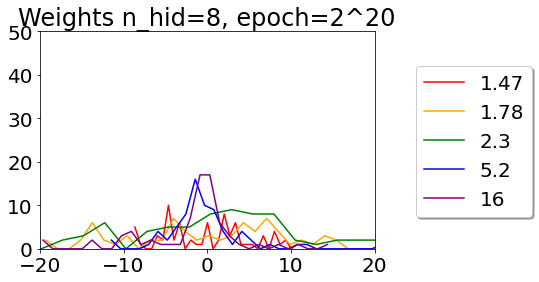

In [109]:
x_dict={}
y_dict={}
for T in T_list:
    x_dict[str(T)]={}
    y_dict[str(T)]={}
    for n_hid in n_hid_list:
        x1, y1=get_hist(Weights[str(T)][str(n_hid)])
        x_dict[str(T)][str(n_hid)]=x1
        y_dict[str(T)][str(n_hid)]=y1

for j in range(21):
    plt.figure(figsize=(8,5))

    n_vis=9
    Weights={}
    for T in T_list:
        Weights[str(T)]={}
        for n_hid in n_hid_list:
            Weight=[]
            models=pd.read_pickle('{base}/loss_IG/3*3/state_dict/model_n_hid={n_hid}_T={T}_lr={lr}_vol={vol}_std_{std}.pkl'.format(base=base, n_hid=n_hid, T=T, lr=lr, vol=vol, std=std))
            Weights[str(T)][str(n_hid)]=models[j]['Weight'].view(9*n_hid)    
    x_dict={}
    y_dict={}
    for T in T_list:
        x_dict[str(T)]={}
        y_dict[str(T)]={}
        for n_hid in n_hid_list:
            x1, y1=get_hist(Weights[str(T)][str(n_hid)])
            x_dict[str(T)][str(n_hid)]=x1
            y_dict[str(T)][str(n_hid)]=y1

    
    for i in range(1, len(n_hid_list)+1):
        n_hid=str(n_hid_list[i-1])
#         plt.subplot(2, 4, i)
        plt.rcParams["font.size"] = "20"
        plt.title('Weights n_hid={n_hid}, epoch=2^{j}'.format(n_hid=n_hid,j=j))
        plt.xlim(-20, 20)
        plt.ylim(0, 50)

        for t in range(len(T_list)):
            plt.plot(x_dict[str(T_list[t])][str(n_hid)], y_dict[str(T_list[t])][str(n_hid)], c=T_color[t], label = T_list[t])
    plt.savefig('{base}/loss_IG/3*3/imgs/{j}.png'.format(base=base, j=j))

#     plt.yscale('log')
    plt.xlim(-20, 20)
#     plt.ylim(0, 1400)
plt.legend(loc='lower right', bbox_to_anchor=(1.5, 0.1), 
        ncol=1, fancybox=True, shadow=True)
    # plt.ylim(1, 10000)

In [110]:
def save():
    os.system("ffmpeg -r 1 -i {base}/loss_IG/3*3/imgs/%01d.png -vcodec mpeg4 -y {base}/loss_IG/3*3/imgs/movie.mp4".format(base=base))
import os
save()